In [1]:
import requests
import asyncio
from datetime import datetime
import pandas as pd
import numpy as np
from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt
from jinja2 import Environment, FileSystemLoader

In [2]:

def format_date(s):
    return datetime.fromtimestamp(s).strftime("%d/%m/%Y %H:%M")
    
env = Environment(
    loader=FileSystemLoader("./templates/")
)
env.filters['format_date'] = format_date

template = env.get_template("match_page.md")
template_player = env.get_template("player_page.md")
template_resume = env.get_template("resume_page.md")

In [3]:
def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)

    return wrapped

def get_headers():
    return {
        'authority': 'api.sofascore.com',
        'accept': '*/*',
        'accept-language': 'pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7',
        'cache-control': 'max-age=0',
        'if-none-match': 'W/"f630e5189c"',
        'origin': 'https://www.sofascore.com',
        'referer': 'https://www.sofascore.com/',
        'sec-ch-ua': '"Chromium";v="118", "Google Chrome";v="118", "Not=A?Brand";v="99"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"macOS"',
        'sec-fetch-dest': 'empty',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-site',
        'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36',
    }

In [4]:

def get_rounds(tournament_id, season_id):
    response = requests.get(
        f"https://api.sofascore.com/api/v1/unique-tournament/{brasileirao_id}/season/{season_id}/rounds",
        headers=get_headers()
    )
    return response.json()


def get_round(tournament_id, season_id, round_id):
    # print(round)
    response = requests.get(
        f"https://api.sofascore.com/api/v1/unique-tournament/{brasileirao_id}/season/{season_id}/events/round/{round_id}",
        headers=get_headers()
    )
    # print(response.json())
    return response.json()


def teams_playes_game(event):
    return [event.get("homeTeam").get("id"), event.get("awayTeam").get("id")]




In [5]:
def get_all_rounds(tournament_id, season_id, times_dict, last_n=None):
    rounds = get_rounds(tournament_id, season_id)
    range_rounds = (
        range(
            rounds.get("rounds")[0].get("round"), 
            rounds.get("currentRound").get("round") + 1
        ) if not last_n
        else range(
            rounds.get("currentRound").get("round") - last_n + 1, 
            rounds.get("currentRound").get("round") + 1
        )
    )
    print([round for round in range_rounds])
    all_events = {
        time.get("name"): [
            event
            for round in range_rounds
            for event in get_round(brasileirao_id, season_id, round).get("events")
            if (
                event.get("homeTeam").get("id") == time.get("id")
                or event.get("awayTeam").get("id") == time.get("id")
            )
        ]
        for time in times_dict
    }
    return all_events
        # print(round)

In [6]:
@background
def get_matches(team_id, i=0):
    response = requests.get(
        f"https://api.sofascore.com/api/v1/team/{team_id}/events/last/{i}",
        headers=get_headers()
    )
    try:
        response.raise_for_status()
        data = response.json()
        return data.get("events")
    except Exception as e:
        # print(e)
        return []


# @background
async def get_route_by_match(match_id, route):
    response = requests.get(
        f'https://api.sofascore.com/api/v1/event/{match_id}{route}', 
        headers=get_headers()
    )
    try:
        response.raise_for_status()
        data = response.json()
        # print(route, match_id, data)
        return data
    except Exception as e:
        # print(e)
        return {}


async def get_data_by_match(match_id):
    return await get_route_by_match(match_id, '/')

async def get_pregame_form_by_match(match_id):
    return await get_route_by_match(match_id, '/pregame-form')

async def get_shotmap_by_match(match_id):
    return await get_route_by_match(match_id, '/shotmap')

async def get_statstics_by_match(match_id):
    return await get_route_by_match(match_id, '/statistics')

async def get_lineups_by_match(match_id):
    return await get_route_by_match(match_id, '/lineups')

async def get_avg_positions_by_match(match_id):
    return await get_route_by_match(match_id, '/average-positions')


@background
def get_heatmap_by_player(match_id, player_id):
    response = requests.get(
        f"https://api.sofascore.com/api/v1/event/{match_id}/player/{player_id}/heatmap",
        headers=get_headers()
    )
    try:
        response.raise_for_status()
        data = response.json()
        return data
    except Exception as e:
        # print(e)
        return {}


async def get_record_by_match(match_id):
    avg_positions = await get_avg_positions_by_match(match_id)
    # print(avg_positions)
    lineups = await get_lineups_by_match(match_id)
    # print(lineups)
    pre_game_form = await get_pregame_form_by_match(match_id)
    # print(pre_game_form)
    asyncio.sleep(0.3)
    match = {
        "match": {
            **await get_data_by_match(match_id),
            **await get_shotmap_by_match(match_id),
            **await get_statstics_by_match(match_id),
            "pre_game_form": pre_game_form,
            "lineups": lineups,
            "avg_positions": avg_positions,
        }
    }
    return match 


async def get_full_data(all_events):
    new_events = {}
    for team, events in all_events.items():
        new_events[team] = []
        # print(events)
        for event in events:
            new_events[team].append(await get_record_by_match(event.get("id")))
    return new_events

In [7]:

def plot_average_positions_by_player(dfs_lineups, player, ax, pitch, color, legend_color, side):
    df_side = dfs_lineups.get(side)
    # print(
    #  df_side[df_side["player_id"] == player.get("player", {}).get("id")].iloc[0] 
    # )
    pitch.scatter(
        player.get("averageX"), 
        player.get("averageY"), 
        s=150, 
        color=color, 
        zorder=3,
        ax=ax,
    )
    pitch.text(
        player.get("averageX"), 
        player.get("averageY"), 
        s=df_side[df_side["player_id"] == player.get("player", {}).get("id")]["shirtNumber"].iloc[0], 
        color=legend_color, 
        fontsize=8, 
        ha='center', 
        va='center',
        ax=ax
    )

def get_players_out(substitutions):
    return [
        substitution.get("playerOut", {}).get("name")
        for substitution in substitutions
    ]

def get_players_in(substitutions):
    return [
        substitution.get("playerIn", {}).get("name")
        for substitution in substitutions
    ]


def plot_average_positions_by_team(game, name, side, color, ax, pitch, titulares, legend_color="white"):
    positions = game.get("match").get("avg_positions")
    substitutions = positions.get("substitutions", {})
    
    lineups = game.get("match").get("lineups")
    # print(lineups)
    lineups.pop("confirmed", {})
    
    dfs_lineups = {
        key: pd.DataFrame(
            pd.json_normalize(value.get("players"), sep="_")
        )
        for key, value in lineups.items()
    }
    
    for player in positions.get(side):
        if titulares:
            if player.get("player", {}).get("name") not in get_players_in(substitutions):
                plot_average_positions_by_player(dfs_lineups, player, ax, pitch, color, legend_color, side)
        else:
            if player.get("player", {}).get("name") not in get_players_out(substitutions):
                plot_average_positions_by_player(dfs_lineups, player, ax, pitch, color, legend_color, side)

    ax.set_title(name.title(), color=legend_color)



# def get_lineups_by_match(match_id):
#     response = requests.get(
#         f'https://api.sofascore.com/api/v1/event/{match_id}/lineups', 
#         headers=get_headers()
#     )
#     try: 
#         response.raise_for_status()
#         data = response.json()
#         return data
#     except Exception as e:
#         print(e)
#         return []

async def create_heatmap_by_player(game, player):
    try:
        df = pd.DataFrame(
            ( await get_heatmap_by_player(game.get("match").get("event").get("id"), player.get("player").get("id"))).get("heatmap")
        )
        
        # setup pitch
        pitch = VerticalPitch(
            pitch_type='opta', 
            line_zorder=2,
            pitch_color='black', 
            line_color='#efefef'
        )
        
        # draw
        fig, ax = pitch.draw(
            figsize=(10, 5),
        )
        fig.set_facecolor('black')
        
        pitch.kdeplot(
            df.x, 
            df.y, 
            ax=ax, 
            cmap='pink', 
            n_levels=500, 
            fill=True, 
            zorder=1
        )
        plt.savefig(f'outputs/players/heatmaps/{game.get("match").get("event").get("id")}_{player.get("player").get("id")}.png')
        plt.close()
    except:
        pass

def plot_avg_positions_by_match(game):    # TESTES
    
    # setup pitch
    pitch = VerticalPitch(
        pitch_type='opta', 
        line_zorder=2,
        pitch_color='green', 
        line_color='#efefef'
    )
    
    # draw
    fig, ax = pitch.draw(
        figsize=(10, 5),
        ncols=2,
    )
    fig.set_facecolor('black')

    SO_TITULARES = True
    
    plot_average_positions_by_team(
        game=game,
        name=game.get("match").get("event").get("homeTeam").get("name"), 
        side='home', 
        color=f"""#{game.get("match").get("lineups").get("home").get("playerColor").get("primary")}""", 
        ax=ax[0],
        pitch=pitch,
        titulares=SO_TITULARES,
        legend_color=f"""#{game.get("match").get("lineups").get("home").get("playerColor").get("number")}""", 
    )
    
    plot_average_positions_by_team(
        game=game,
        name=game.get("match").get("event").get("awayTeam").get("name"), 
        side='away', 
        color=f"""#{game.get("match").get("lineups").get("away").get("playerColor").get("primary")}""", 
        ax=ax[1],
        pitch=pitch,
        titulares=SO_TITULARES,
        legend_color=f"""#{game.get("match").get("lineups").get("away").get("playerColor").get("number")}""", 
    )
    plt.savefig(f'outputs/games/avg_positions/{game.get("match").get("event").get("id")}.png')
    plt.close()



In [8]:
def get_player_shotmap(shotmaps, player):
    return [
        shot
        for shot in shotmaps
        if shot.get("player").get("id") == player.get("player").get("id")
    ]

In [9]:

def generate_shotmaps_by_player(player, game, shotmaps, color):
    # print(shotmaps)
    pitch = VerticalPitch(
        pitch_type='opta',
        pitch_color='black', 
        line_color='white',
        goal_type='box',
        goal_linestyle='--',
        corner_arcs=True,
        # axis=True,
        # label=True,
        # positional=True, 
        # shade_middle=True
        # half=True,
        )
    
    fig, ax = pitch.draw(figsize=(10, 5))
    fig.set_facecolor('black')

    for shot in shotmaps:
        pitch.arrows(
            shot.get("draw").get("start").get("y"), 
            shot.get("draw").get("start").get("x"), 
            shot.get("draw").get("end").get("y"), 
            shot.get("draw").get("end").get("x"), 
            ax=ax,
            width=3,
            color="#" + color
        )
       
        sc = pitch.scatter(
            [shot.get("playerCoordinates").get("x")], [shot.get("playerCoordinates").get("y")],
            c=["#" + color],
            s=50, 
            label='scatter',
            ax=ax
        )
        
        n = [
            {
                "tipo": shot.get("shotType"),
                "sitação": shot.get("situation"),
                "tipo_do_gol": shot.get("goalType"),
                "tempo": shot.get("time"),
            }
        ]
        data = sc.get_offsets()
        
        for idx,label in enumerate(n):
            ax.text(
                data[idx][0]+2,
                data[idx][1],
                label, 
                color="white"
            )
    
    plt.savefig(f'outputs/players/shotmaps/{game.get("match").get("event").get("id")}_{player.get("player").get("id")}.png')
    plt.close()
    


In [10]:
async def create_game_report(game):
    global template_resume, template, template_player
    print(
        game.get("match").get("event").get("id"),
        "-",
        game.get("match").get("event").get("homeTeam").get("name"), 
        "X", game.get("match").get("event").get("awayTeam").get("name")
    )
    if game.get("match").get("event").get("homeScore").get("display"):
        plot_avg_positions_by_match(game)
        with open(f'outputs/games/{game.get("match").get("event").get("id")}.md', "w") as file:
            file.write(
                template.render(
                    game=game,
                )
            )

        for side, lineup in game.get("match").get("lineups").items():
            for player in lineup.get("players"):
        # for player in game.get("match").get("lineups").get("away").get("players") + game.get("match").get("lineups").get("home").get("players"):
                shotmaps = get_player_shotmap(game.get("match").get("shotmap"), player)
                if len(shotmaps) > 0:
                    generate_shotmaps_by_player(
                        player,
                        game, 
                        shotmaps,
                        lineup.get("playerColor").get("number")
                    )
                await create_heatmap_by_player(game, player)
                with open(f'outputs/players/{game.get("match").get("event").get("id")}_{player.get("player").get("id")}.md', "w") as file:
                    file.write(
                        template_player.render(
                            player=player,
                            game=game,
                            statistics=player.get("statistics")
                        )
                    )

async def create_team_report(team, events):
    print(team)
    global template_resume, template, template_player
    
    with open(f'outputs/resumes/{team}.md', "w") as file:
        file.write(template_resume.render(new_events=events))

    [
        await create_game_report(game)
        for game in events
    ]
    return f'outputs/resumes/{team}.md'

In [11]:
season_id = 48982
brasileirao_id = 325
last_n = 6

times = ["São Paulo", "Fluminense"]

In [16]:
response = requests.get(
    f"https://api.sofascore.com/api/v1/unique-tournament/{brasileirao_id}/season/{season_id}/teams",
    headers=get_headers()
)
data = response.json()
times_dict = [
    time
    for time in data.get("teams", [])
    if time.get("name") in times
]

all_events = get_all_rounds(brasileirao_id, season_id, times_dict, last_n=last_n)
new_events = await get_full_data(all_events)

[28, 29, 30, 31, 32, 33]


/var/folders/l2/sqxyrwkj7gjdf9g85g48xr900000gp/T/ipykernel_15630/2074139023.py:73: RuntimeWarning: coroutine 'sleep' was never awaited
  asyncio.sleep(0.3)


In [14]:
# new_events = list(new_events.items())[:1]

São Paulo
11652579 - São Paulo X Grêmio
11067464 - Palmeiras X São Paulo


/Users/kovi/zambotto/.zambotto_310/lib/python3.10/site-packages/seaborn/distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()
/Users/kovi/zambotto/.zambotto_310/lib/python3.10/site-packages/mplsoccer/_pitch_base.py:429: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,


11067503 - Athletico X São Paulo
11067295 - São Paulo X Cruzeiro
11067392 - Fluminense X São Paulo
11067452 - São Paulo X Red Bull Bragantino
Fluminense
11067443 - Red Bull Bragantino X Fluminense
11067459 - Fluminense X Goiás
11067499 - Atlético Mineiro X Fluminense


/Users/kovi/zambotto/.zambotto_310/lib/python3.10/site-packages/seaborn/distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()


11067343 - Bahia X Fluminense
11067392 - Fluminense X São Paulo
11067484 - Internacional X Fluminense


['outputs/resumes/São Paulo.md', 'outputs/resumes/Fluminense.md']

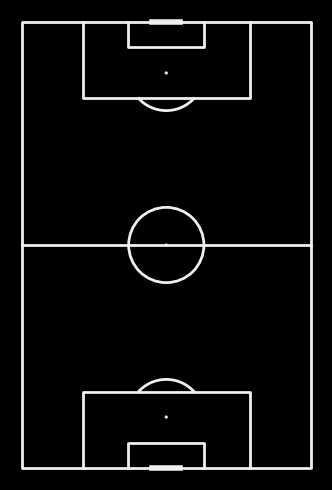

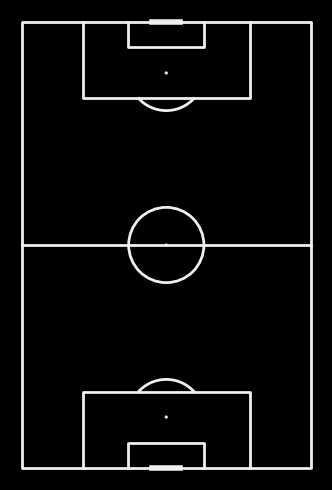

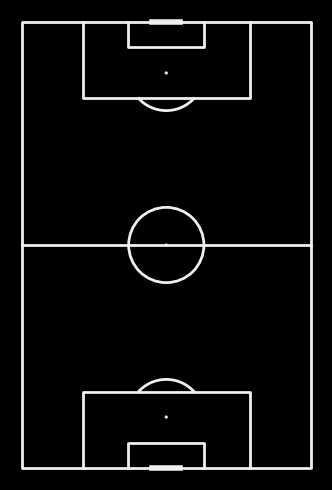

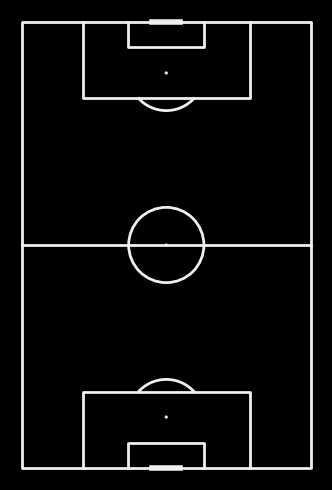

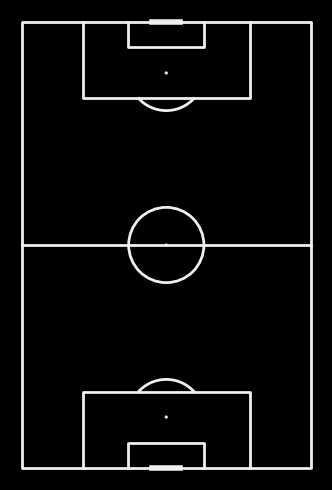

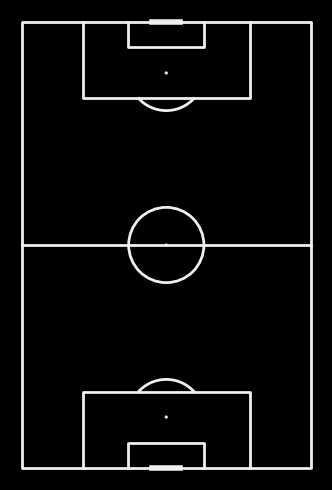

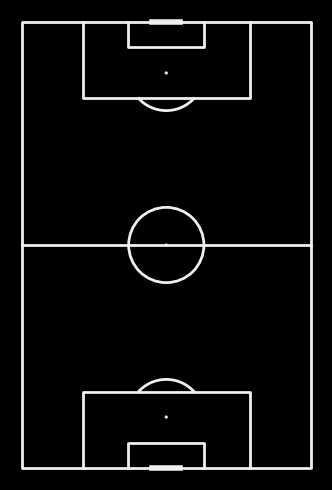

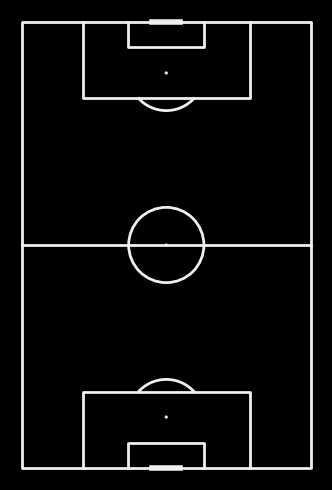

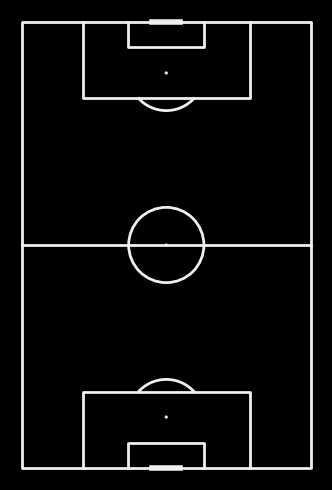

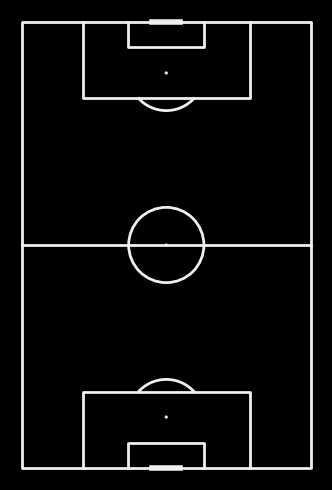

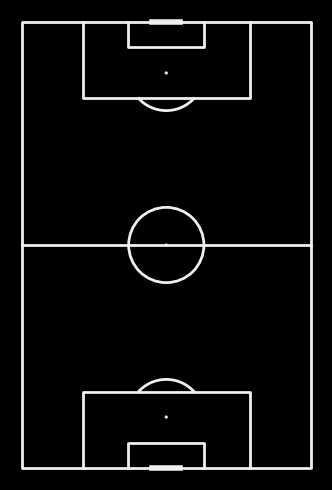

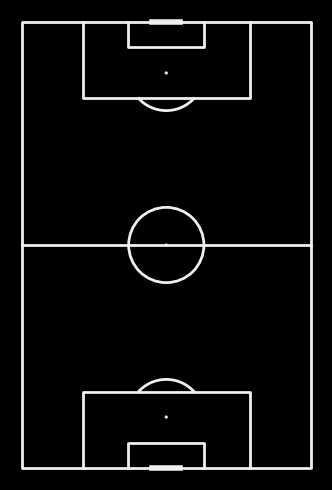

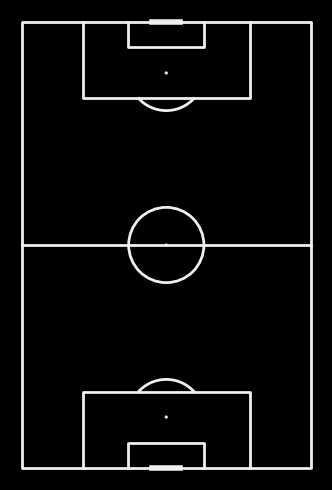

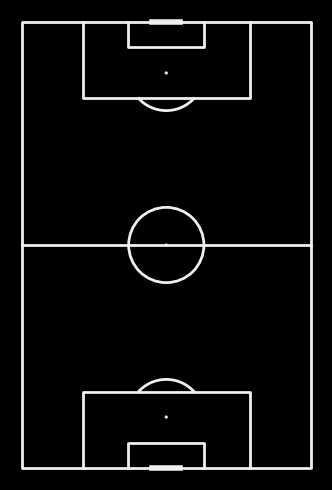

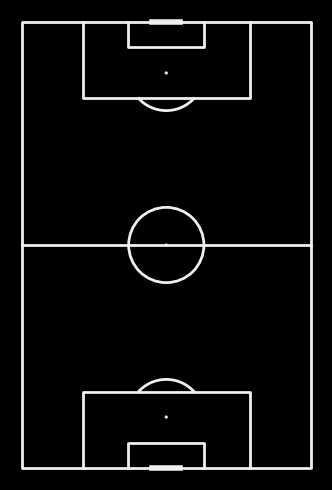

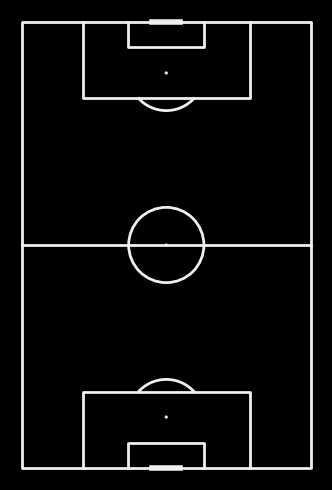

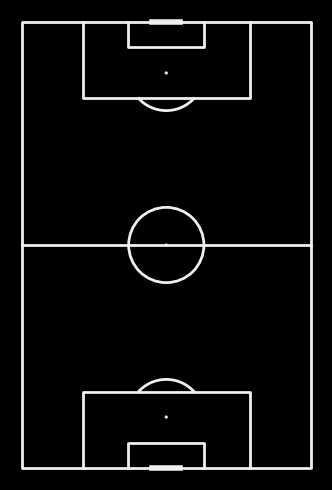

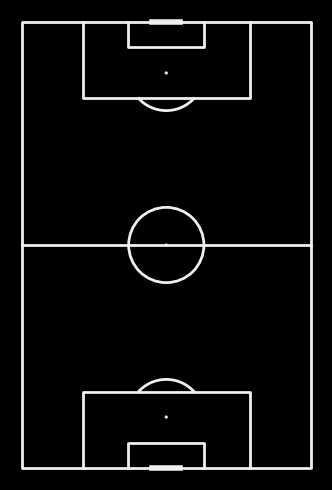

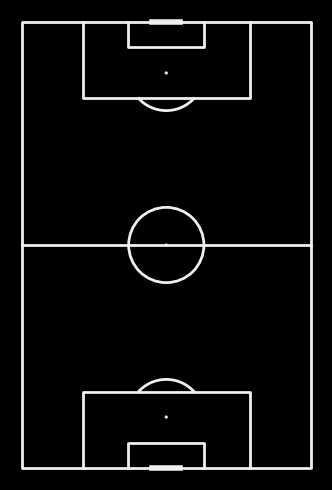

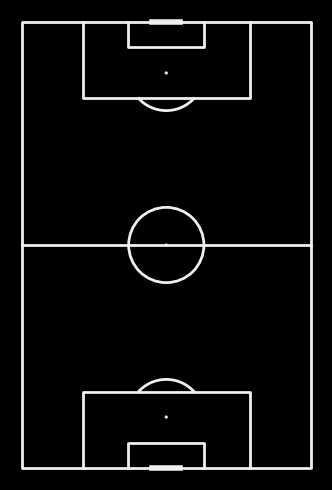

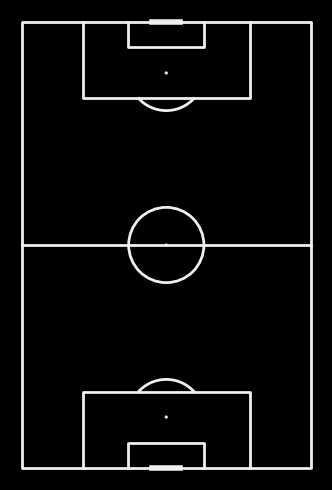

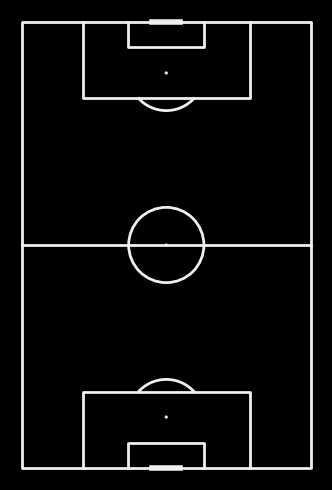

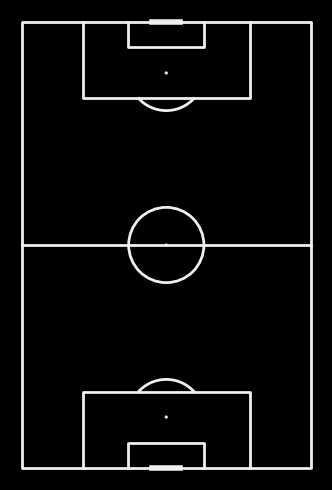

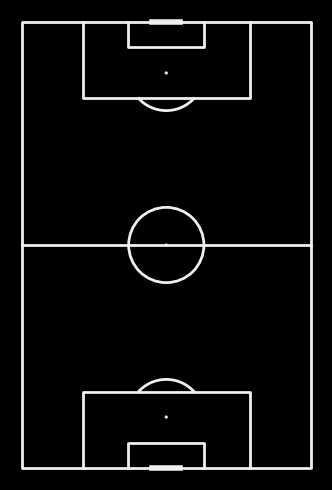

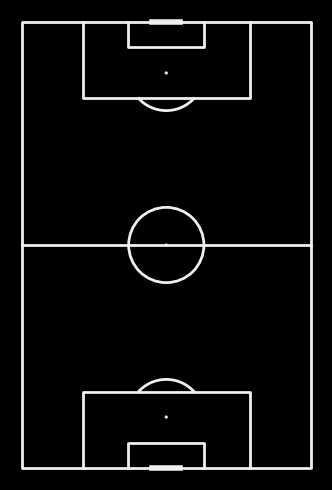

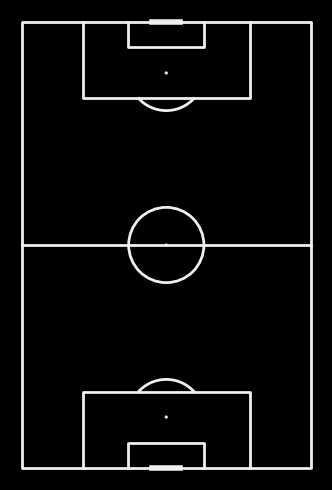

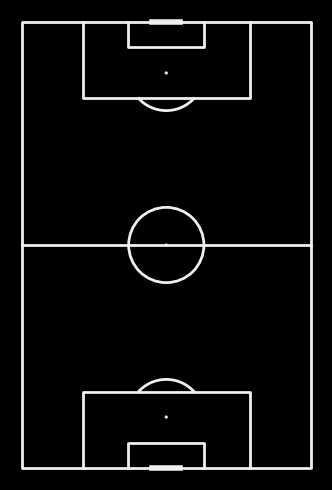

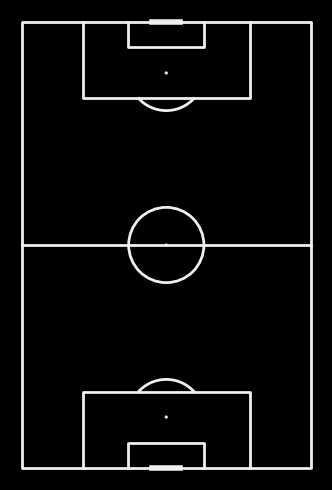

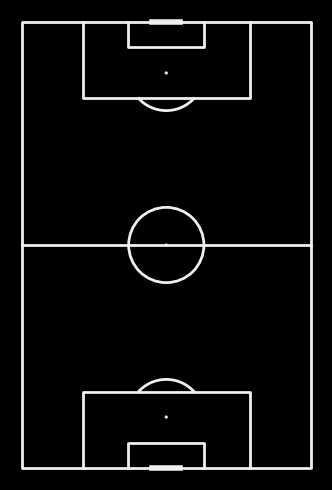

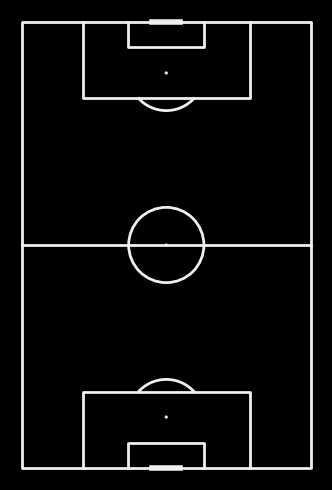

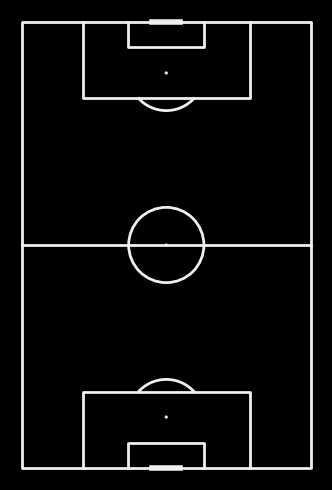

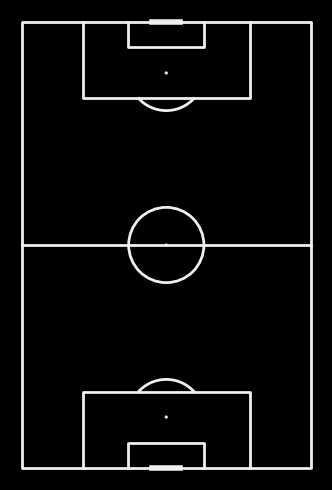

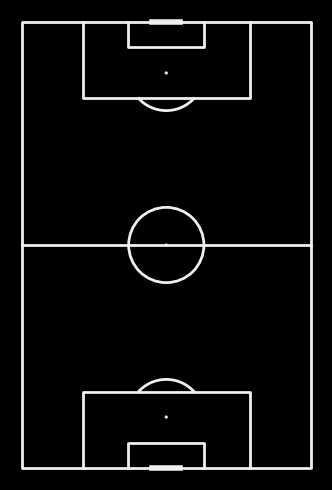

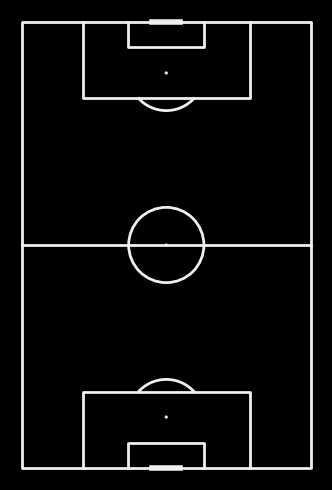

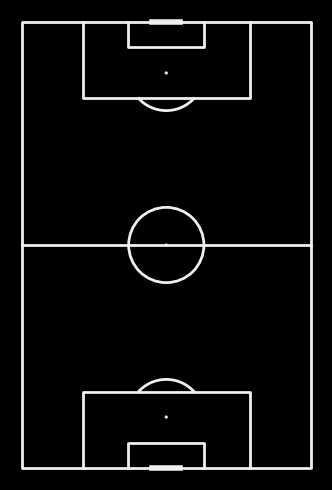

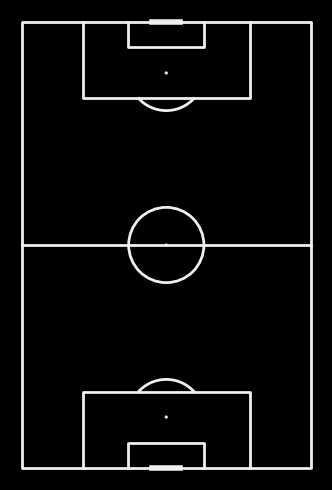

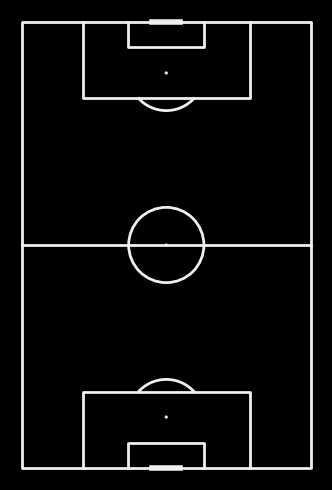

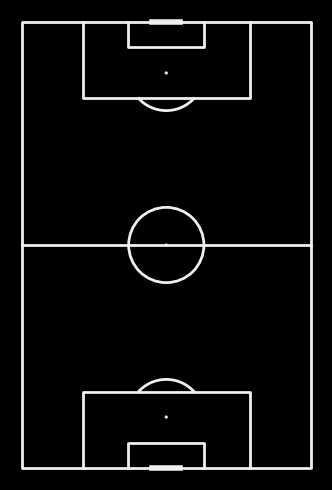

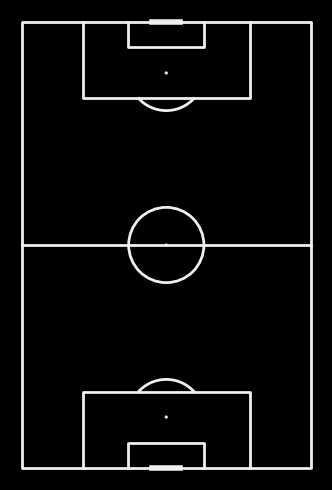

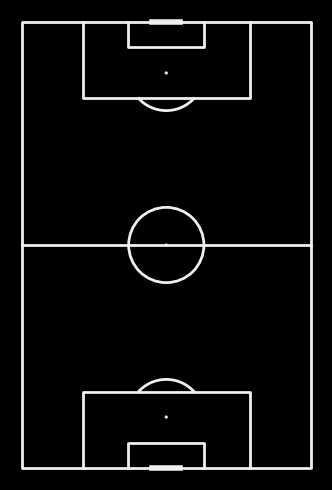

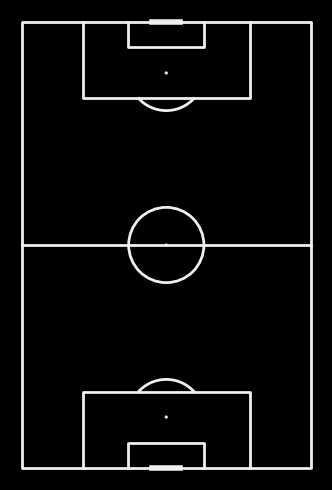

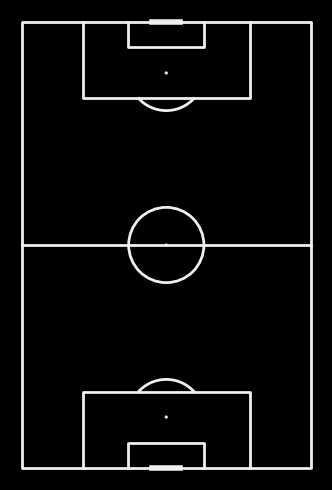

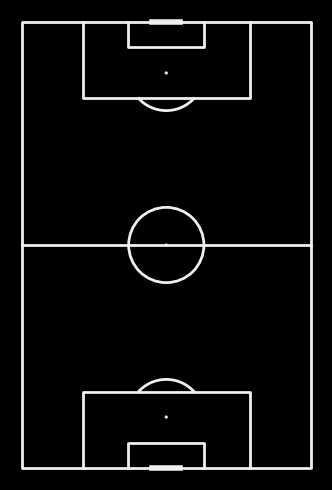

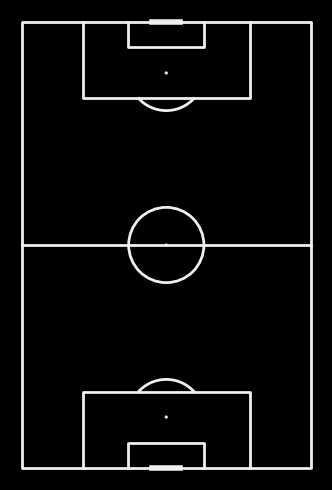

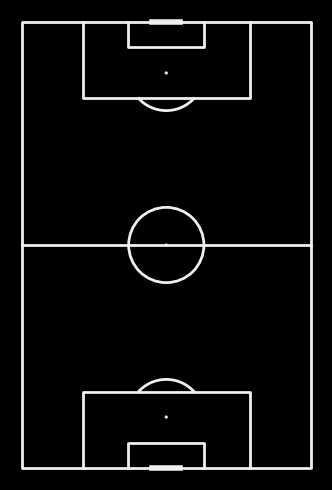

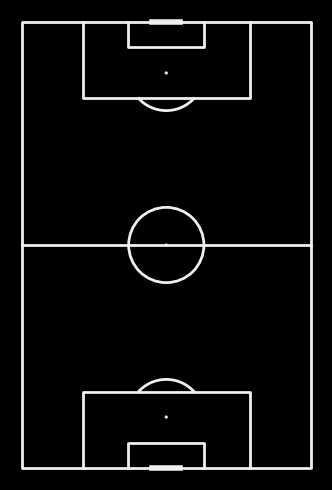

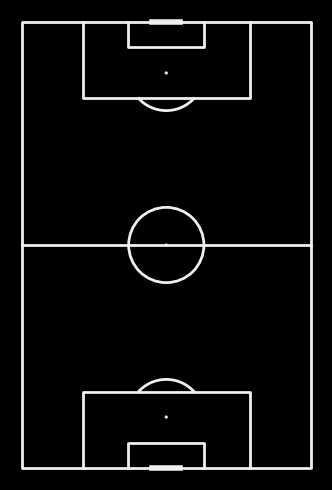

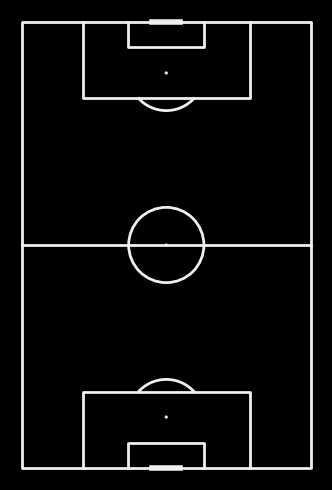

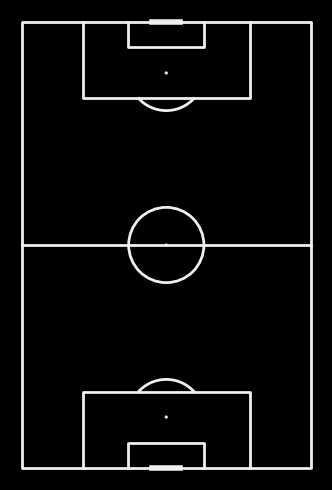

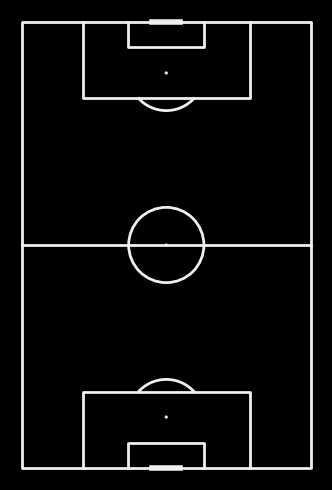

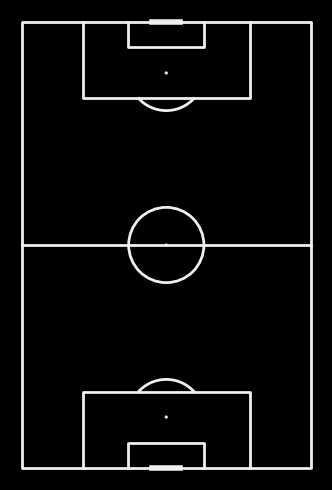

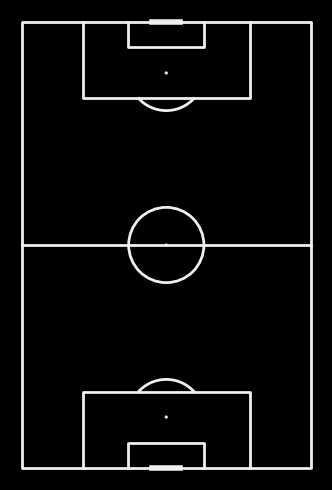

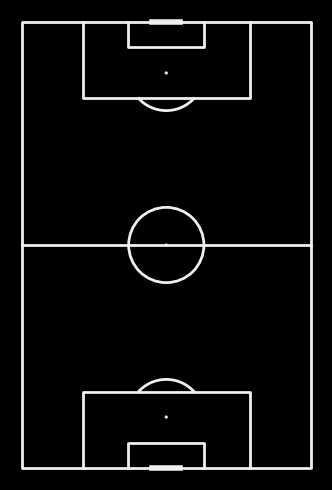

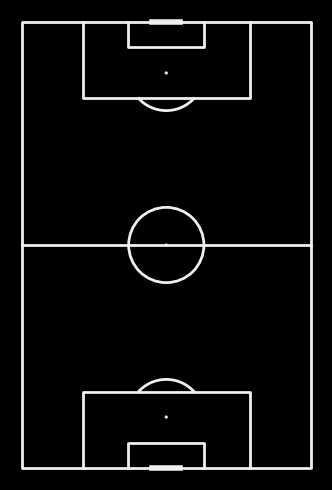

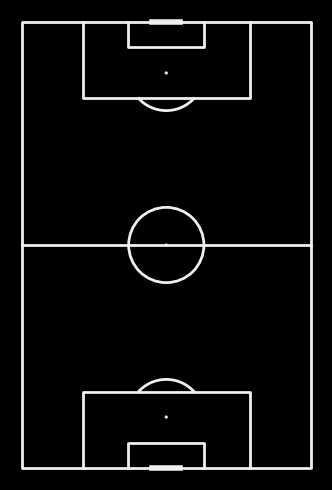

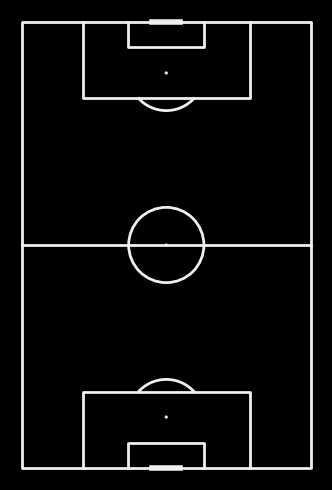

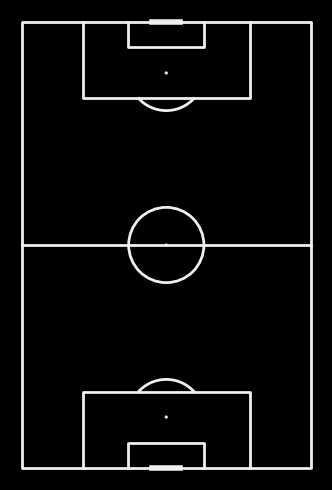

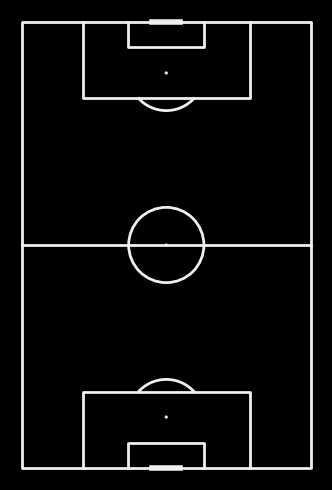

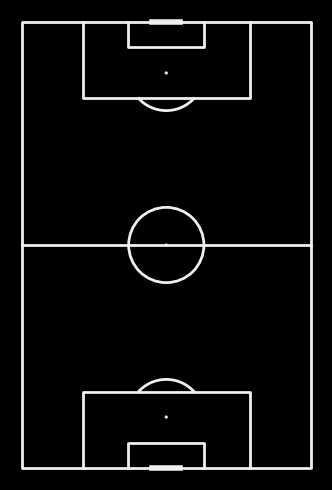

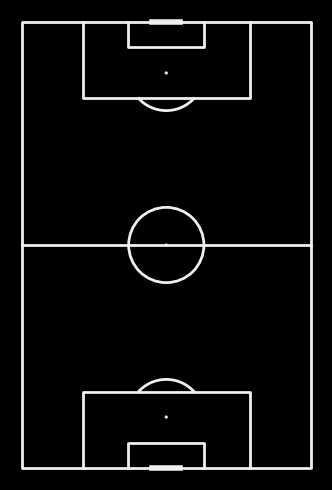

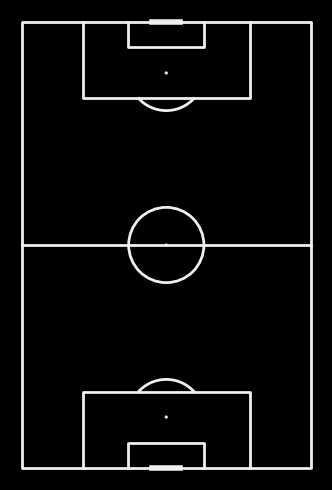

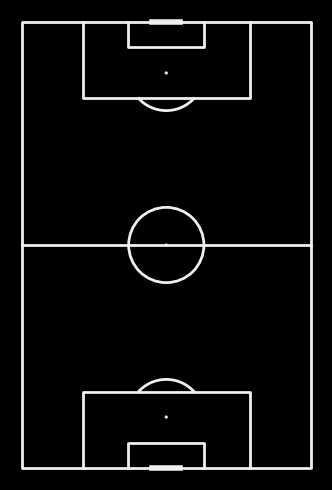

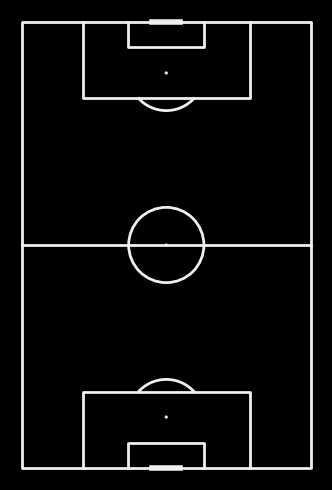

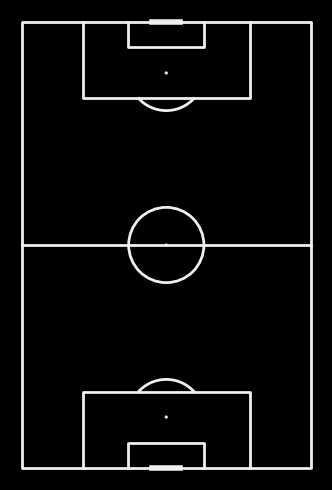

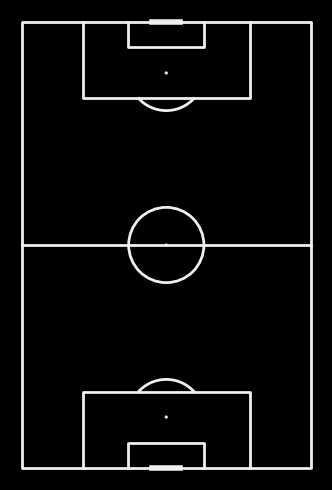

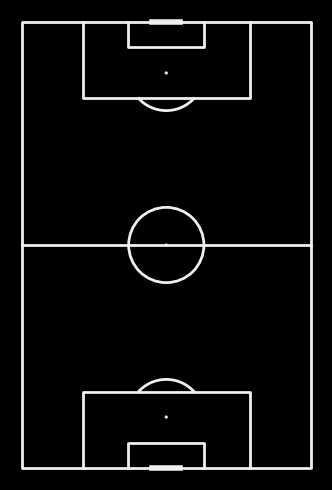

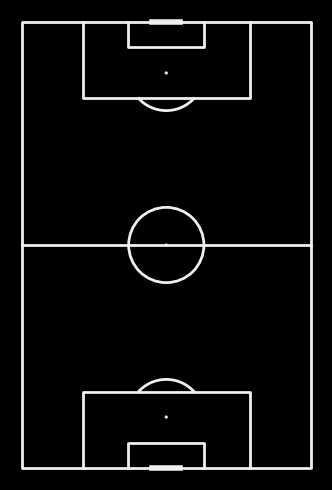

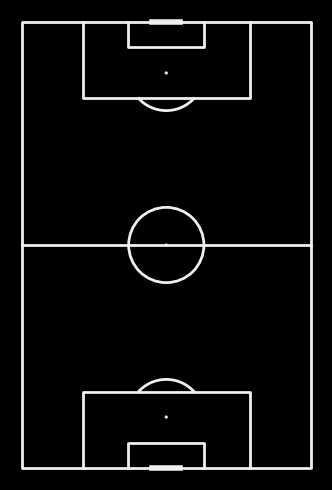

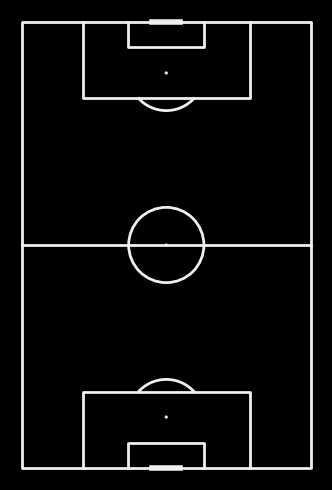

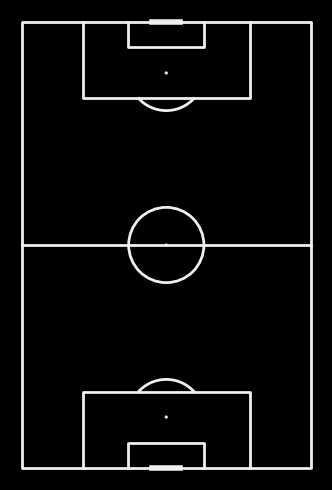

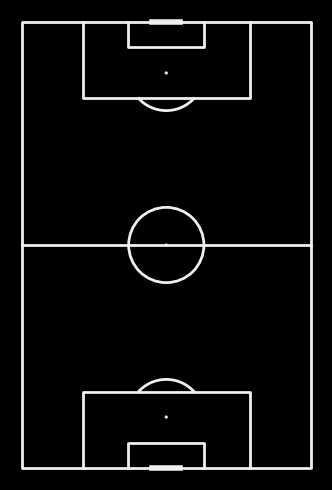

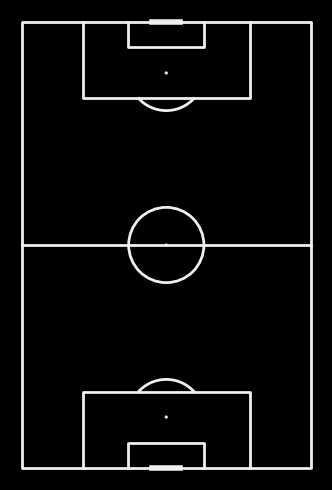

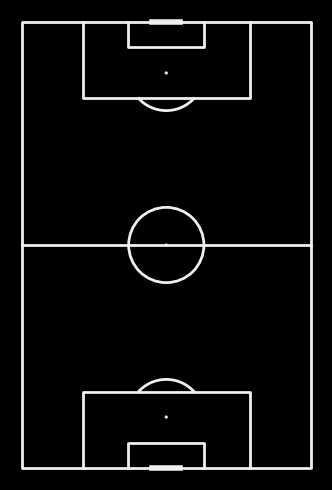

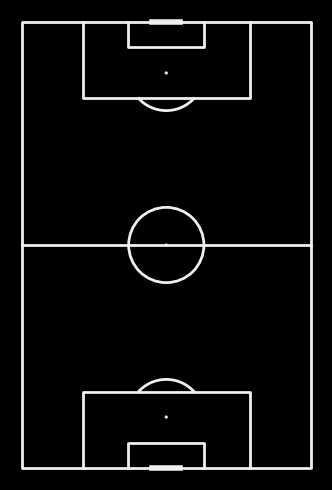

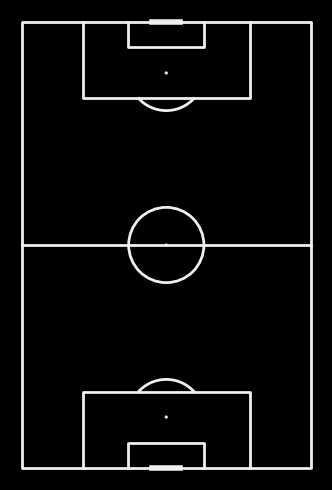

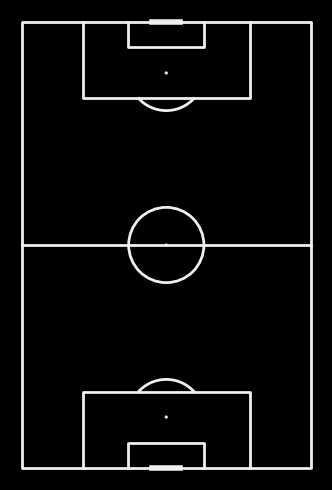

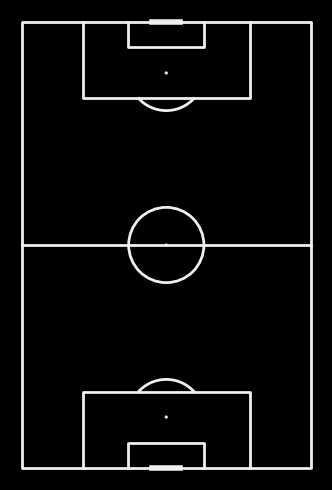

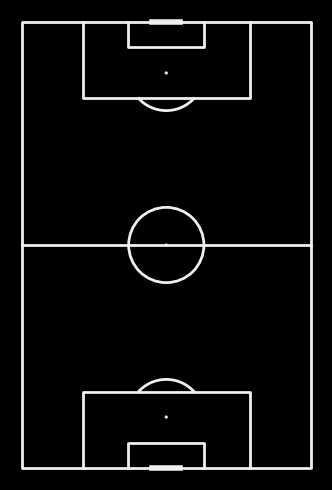

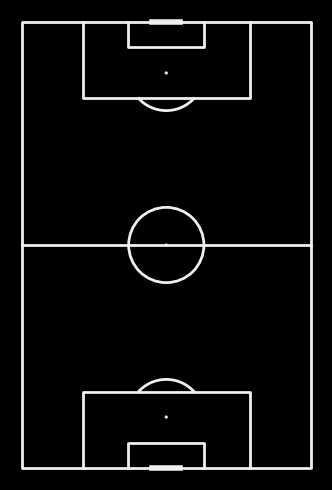

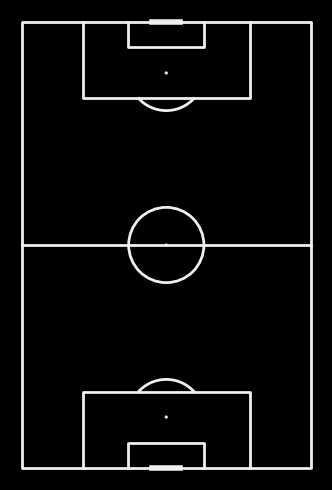

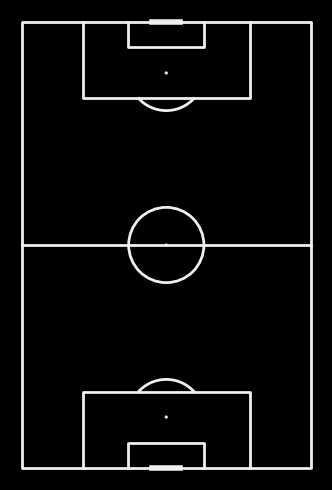

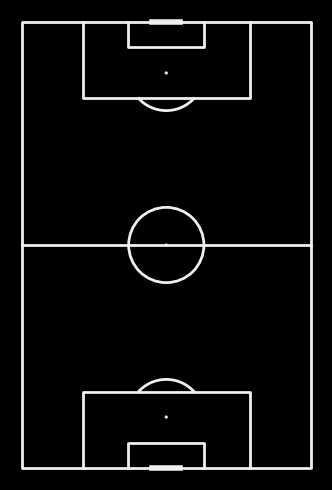

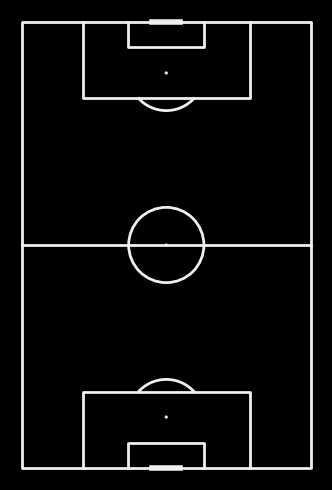

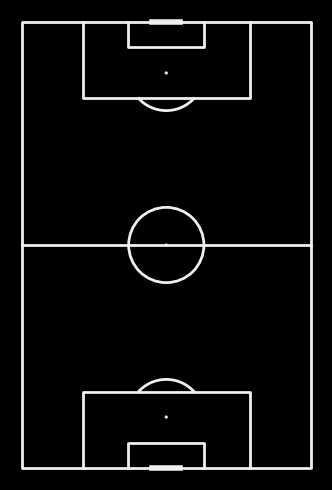

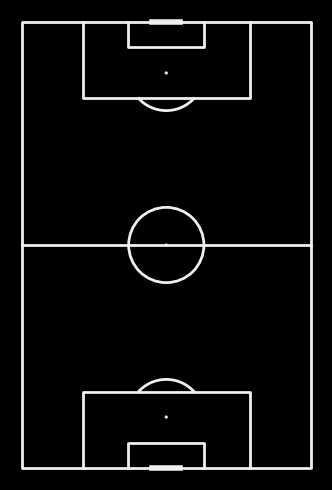

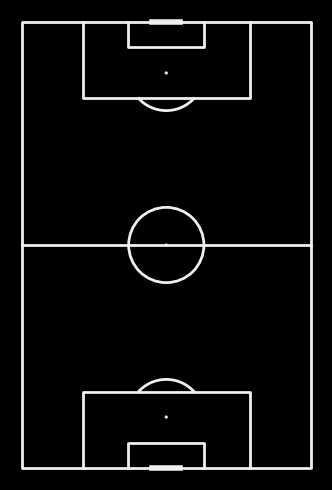

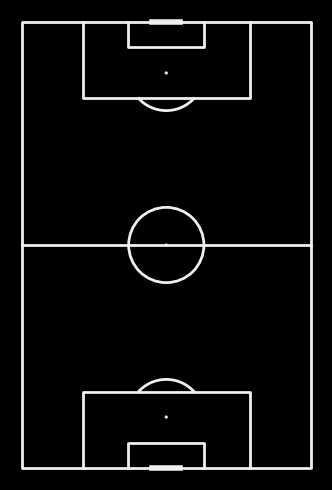

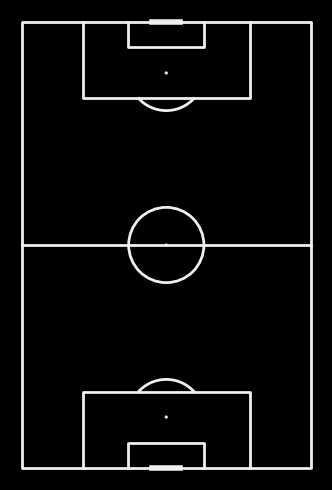

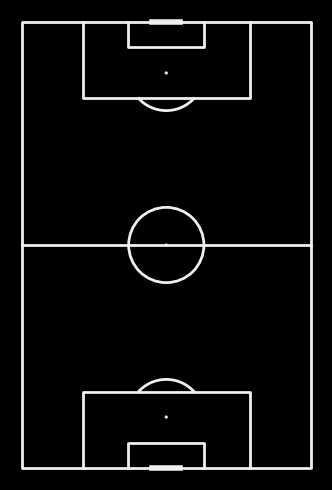

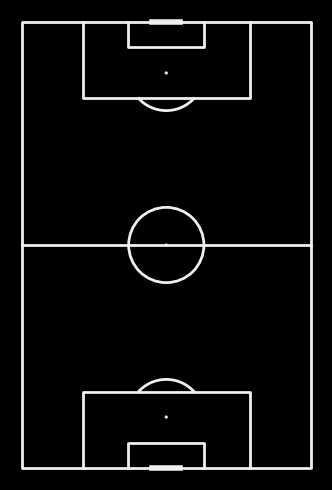

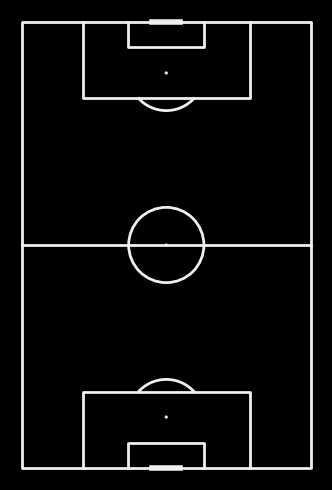

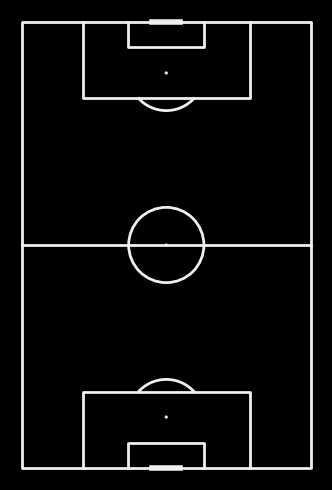

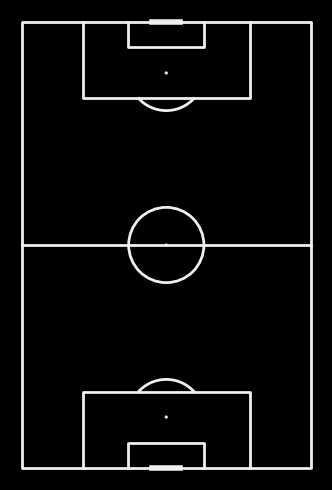

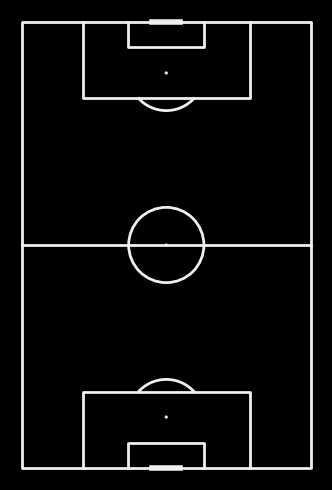

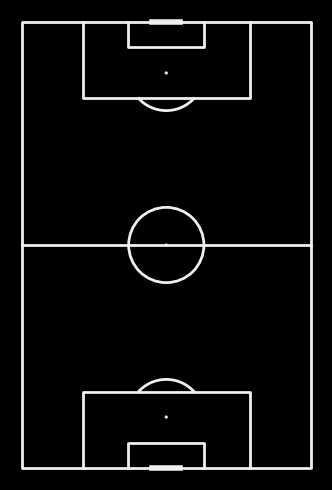

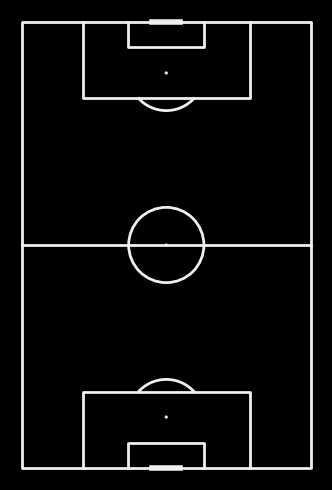

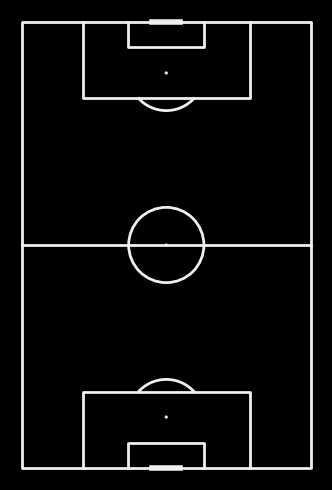

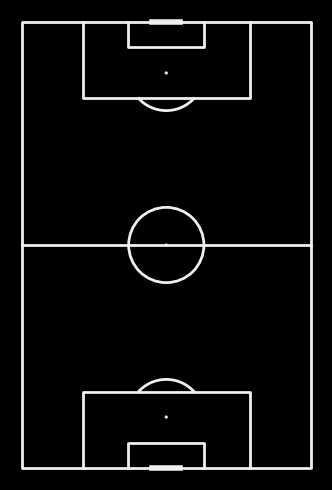

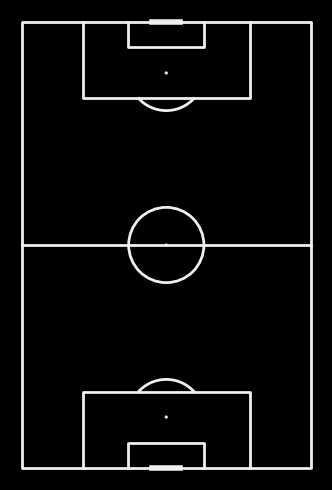

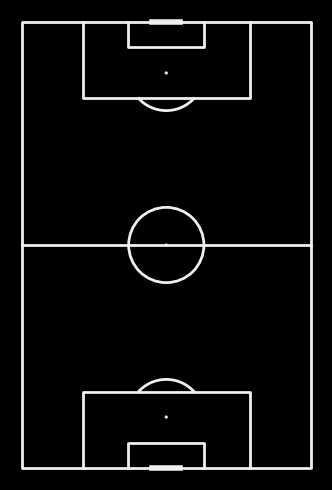

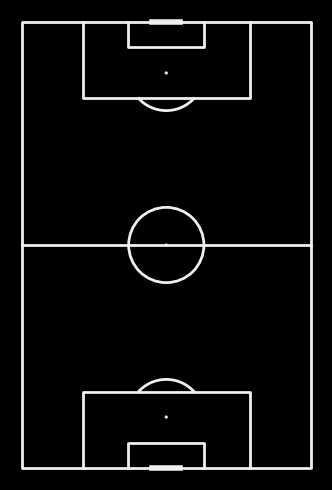

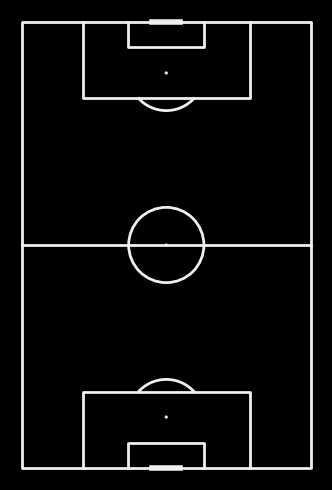

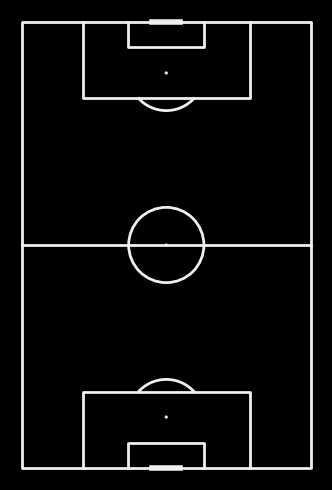

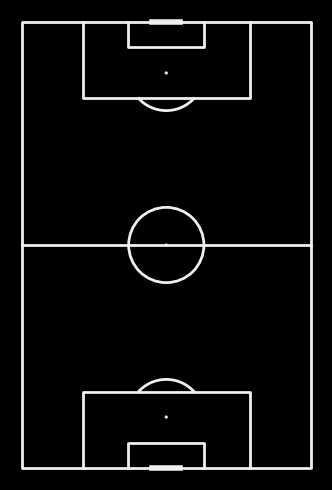

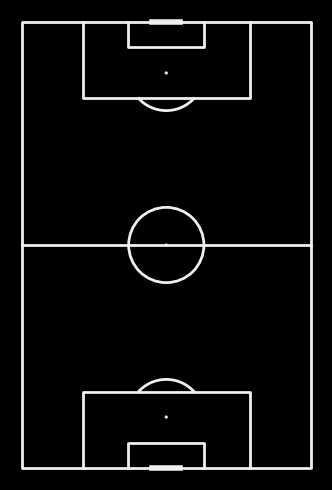

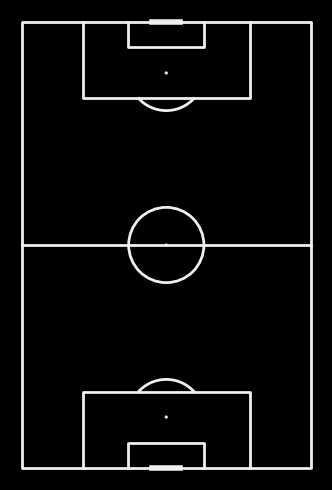

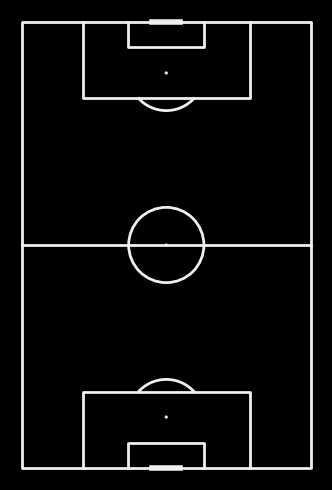

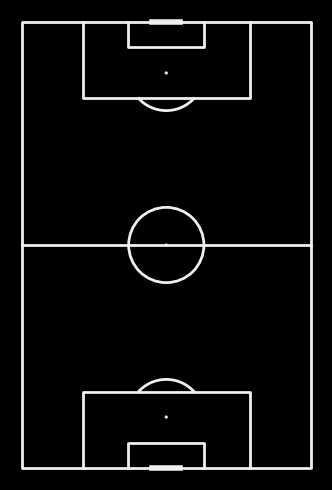

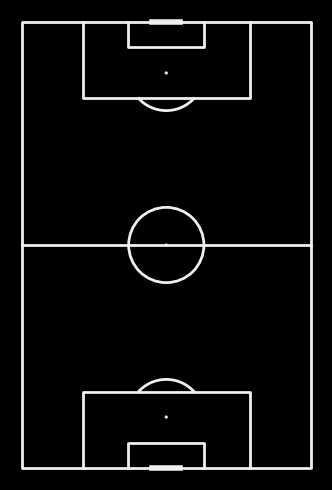

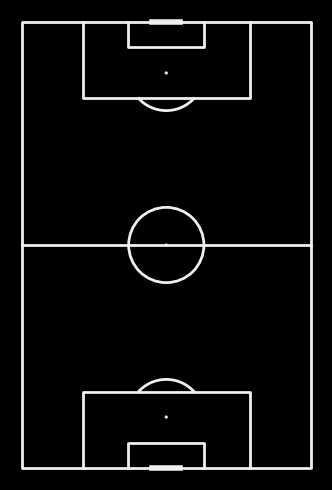

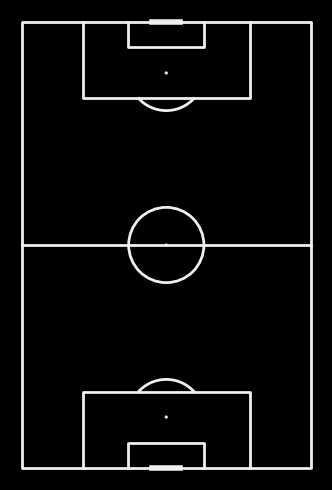

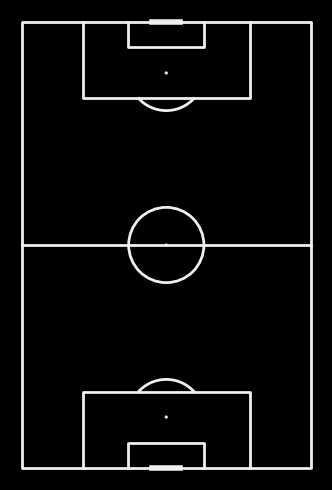

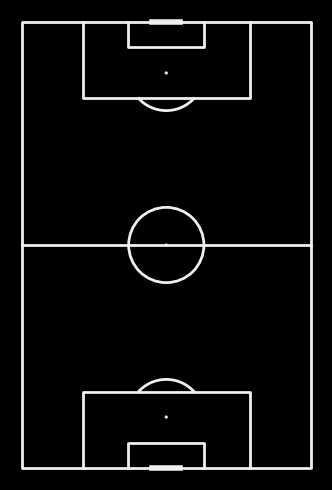

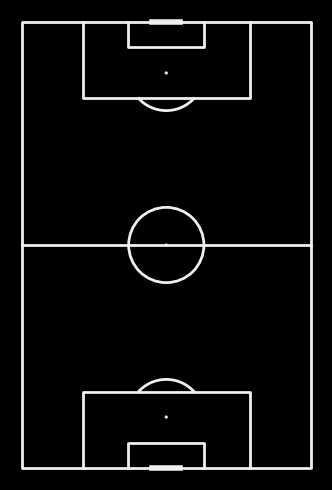

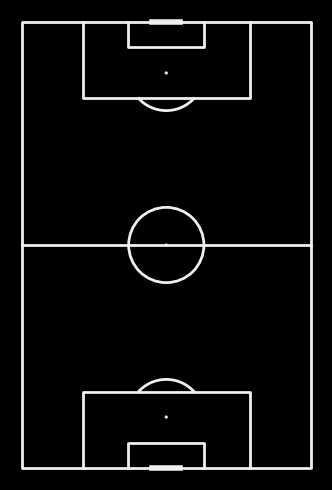

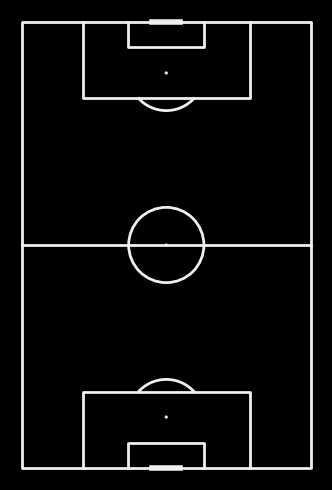

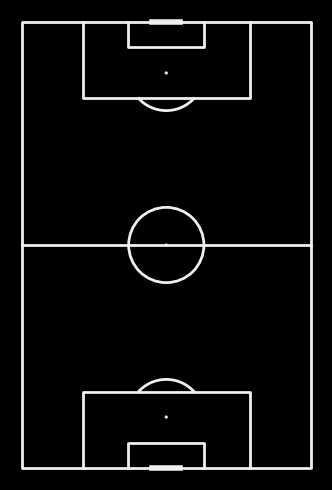

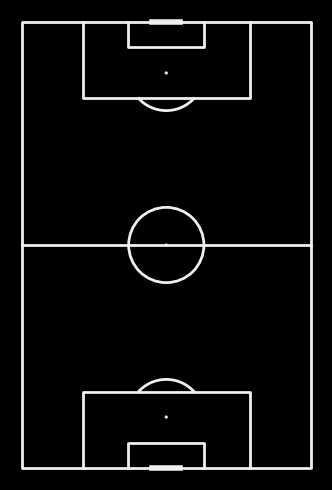

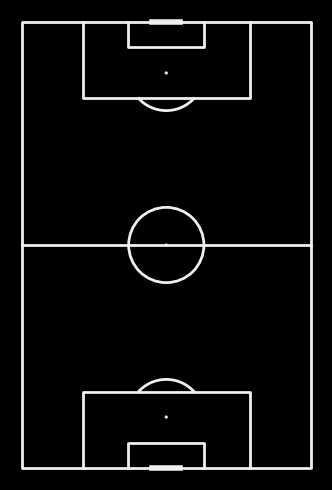

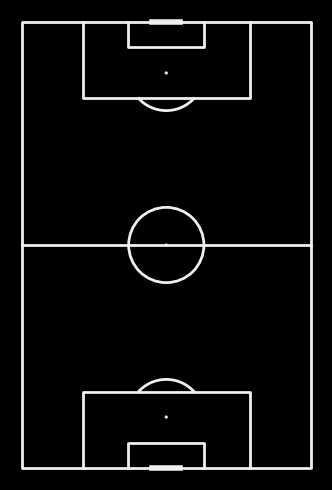

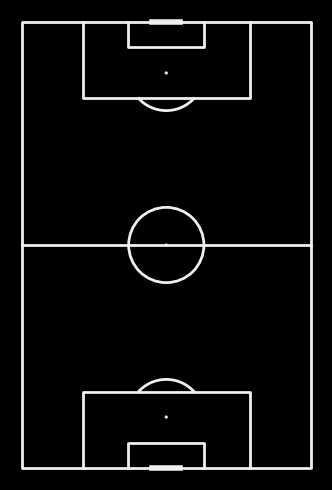

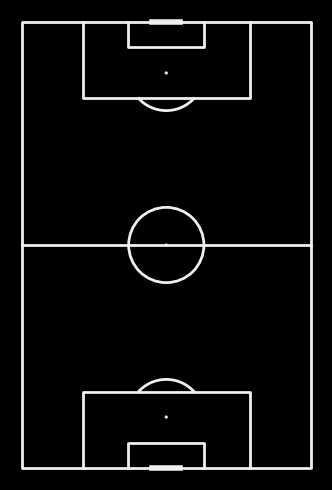

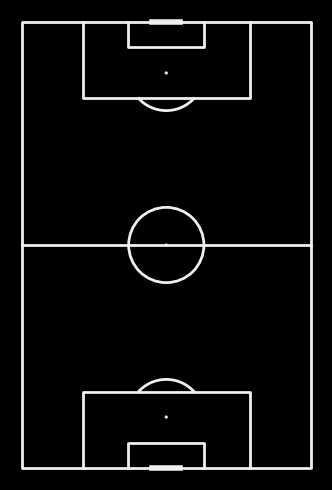

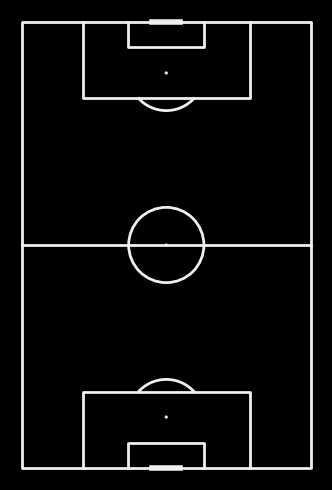

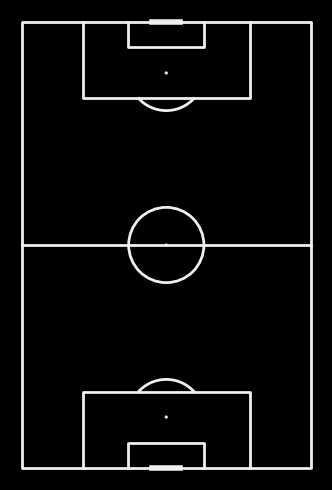

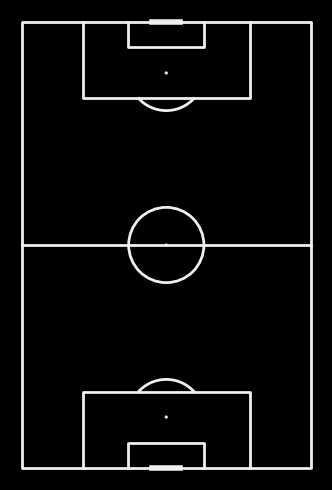

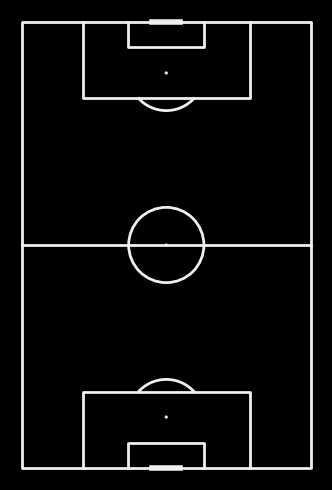

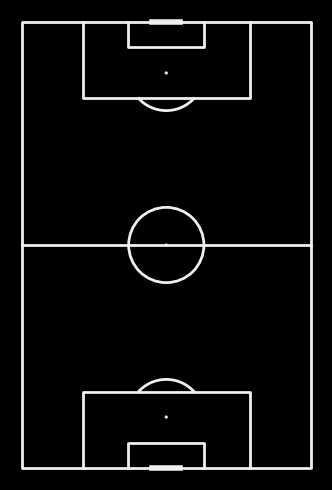

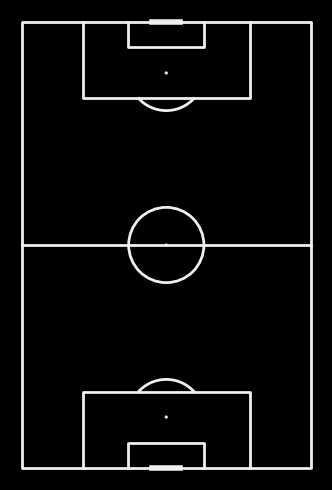

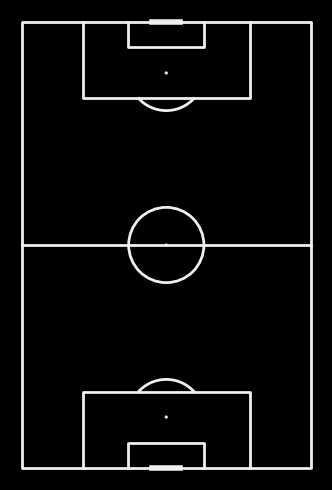

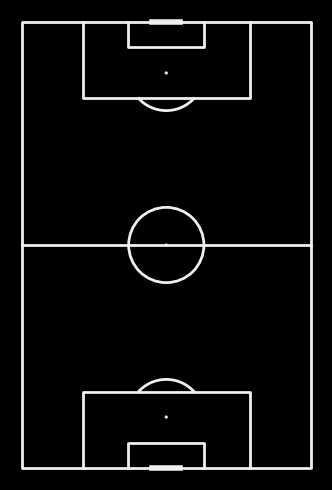

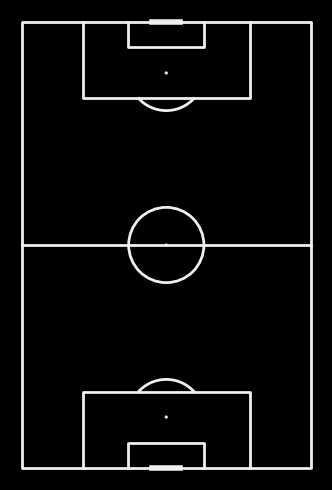

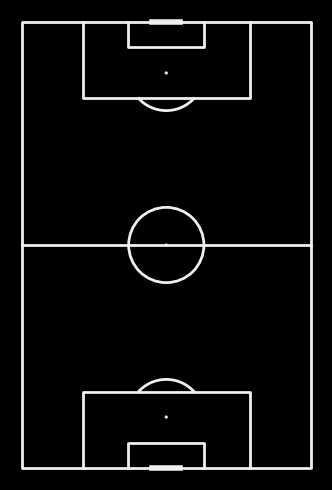

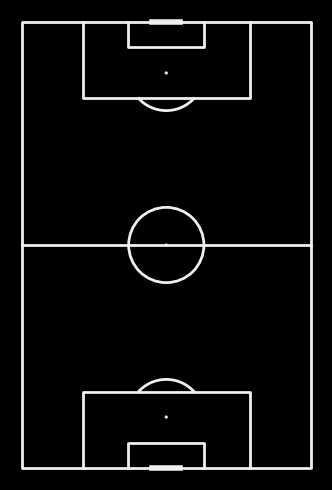

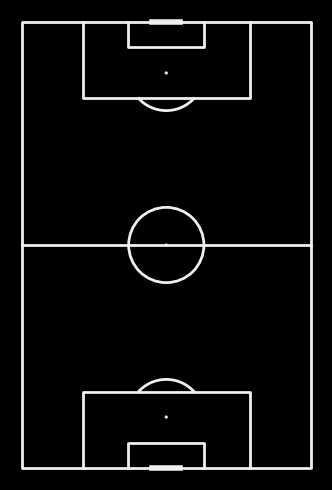

In [17]:
[
    await create_team_report(team, events)
    for team, events in new_events.items()
]

In [ ]:
game = new_events.get("São Paulo")[0]

In [ ]:
[k for k in game.get("match")]

In [ ]:
[lineup.get("players") for side, lineup in game.get("match").get("lineups").items()]

In [ ]:
player = game.get("match").get("lineups").get("away").get("players")[9]
shotmaps = get_player_shotmap(game.get("match").get("shotmap"), player)
color = game.get("match").get("lineups").get("away").get("playerColor").get("number")

In [ ]:
generate_shotmaps_by_player(player, game, shotmaps, color)

In [ ]:

async def get_route_player(player_id, route):
    response = requests.get(
        f'https://api.sofascore.com/api/v1/player/{player_id}{route}', 
        headers=get_headers()
    )
    try:
        response.raise_for_status()
        data = response.json()
        # print(route, match_id, data)
        return data
    except Exception as e:
        # print(e)
        return {}


In [ ]:
player_id = 16943
route = "/image"


In [ ]:
requests.get(
    f'https://api.sofascore.com/api/v1/player/{player_id}{route}', 
    headers=get_headers()
).text

In [ ]:
await get_route_player(16943, "/image")

In [ ]:
player

In [ ]:
game.get("match").get("pre_game_form")

In [ ]:
ax[0]

In [ ]:
pitch = VerticalPitch(
    pitch_type='opta',
    pitch_color='black', 
    line_color='white',
    goal_type='box',
    goal_linestyle='--',
    corner_arcs=True,
    # axis=True,
    # label=True,
    # positional=True, 
    # shade_middle=True
    # half=True,

)

fig, ax = pitch.draw(figsize=(10, 5),)


for shot in shotmaps:
    pitch.arrows(
        shot.get("draw").get("start").get("y"), 
        shot.get("draw").get("start").get("x"), 
        shot.get("draw").get("end").get("y"), 
        shot.get("draw").get("end").get("x"), 
        ax=ax,
        width=3,
        color="#" + color
    )
   
    sc = pitch.scatter(
        [shot.get("playerCoordinates").get("x")], [shot.get("playerCoordinates").get("y")],
        c=["#" + color],
        s=50, 
        label='scatter',
        ax=ax
    )
    
    n = [
        {
            "tipo": shot.get("shotType"),
            "sitação": shot.get("situation"),
            "tipo_do_gol": shot.get("goalType"),
            "tempo": shot.get("time"),
        }
    ]
    data = sc.get_offsets()
    print(data)
    for idx, label in enumerate(n):
        ax.text(
            data[idx][0],
            data[idx][1],
            label, 
            color="white"
        )

In [ ]:
player.get("player").get("id")


In [ ]:
[k for k in player.get("statistics")]

In [ ]:
player.get("statistics")

In [ ]:
for team, events in new_events.items():
    
    with open(f'outputs/resumes/{team}.md', "w") as file:
        file.write(template_resume.render(new_events=events))

    
    for game in events:
        print(game.get("match").get("event").get("id"))
        if game.get("match").get("event").get("homeScore").get("display"):
            plot_avg_positions_by_match(game)
            with open(f'outputs/games/{game.get("match").get("event").get("id")}.md', "w") as file:
                file.write(
                    template.render(
                        game=game,
                    )
                )
            
            for player in game.get("match").get("lineups").get("away").get("players") + game.get("match").get("lineups").get("home").get("players"):
                await create_heatmap_by_player(game, player)
                with open(f'outputs/players/{game.get("match").get("event").get("id")}_{player.get("player").get("id")}.md', "w") as file:
                    file.write(
                        template_player.render(
                            player=player,
                            game=game,
                        )
                    )


In [ ]:
with open(f'sao_paulo.md', "w") as file:
    file.write(template_resume.render(new_events=new_events))

In [ ]:
datetime.fromtimestamp(game[0].get("match").get("event").get("startTimestamp")).strftime("%d/%m/%Y %H:%M")

In [ ]:
plot_avg_positions_by_match(game)
print(game.get("match").get("event").get("id"))
with open(f'{game.get("match").get("event").get("id")}.md', "w") as file:
    file.write(
        template.render(
            game=game,
        )
    )

for player in game.get("match").get("lineups").get("away").get("players") + game.get("match").get("lineups").get("home").get("players"):
    await create_heatmap_by_player(game, player)
    with open(f'players/{game.get("match").get("event").get("id")}_{player.get("player").get("id")}.md', "w") as file:
        file.write(
            template_player.render(
                player=player,
                game=game,
            )
        )


In [ ]:
for player in lineups.get("away").get("players") + lineups.get("home").get("players"):
    with open(f'players/{game.get("match").get("event").get("id")}_{player.get("player").get("id")}.md', "w") as file:
        file.write(
            template_player.render(
                player=player,
                game=game,
            )
        )
    await create_heatmap_by_player(game, player)

In [ ]:
print(
    template.render(titulares_casa=titulares_casa, titulares_fora=titulares_fora)
)

In [ ]:
players1

In [ ]:
for index in range(0, len(new_events.get("São Paulo"))):
    game = new_events.get("São Paulo")[index].copy()
    if game.get("match").get("event").get("homeScore").get("display"):
        print_resultado(game)
        print()
        print_formacoes(game)
        print_jogadores_titular(game)
        
        
        positions = game.get("match").get("avg_positions")
        print([k for k in positions])
        
        substitutions = positions.pop("substitutions", {}) 
        print("Players OUT", get_players_out(substitutions))
        print("Players IN", get_players_in(substitutions))
        
        # TESTES
        
        lineups = game.get("match").get("lineups")
        # print(lineups)
        lineups.pop("confirmed", {})
        
        dfs_lineups = {
            key: pd.DataFrame(
                pd.json_normalize(value.get("players"), sep="_")
            )
            for key, value in lineups.items()
        }
        
        
        
        # setup pitch
        pitch = VerticalPitch(
            pitch_type='opta', 
            line_zorder=2,
            pitch_color='green', 
            line_color='#efefef'
        )
        
        # draw
        fig, ax = pitch.draw(
            figsize=(10, 5),
            ncols=2,
        )
        fig.set_facecolor('black')
        
        
        SO_TITULARES = True
        
        plot_average_positions_by_team(
            name=game.get("match").get("event").get("homeTeam").get("name"), 
            side='home', 
            color=f"""#{game.get("match").get("lineups").get("home").get("playerColor").get("primary")}""", 
            ax=ax[0],
            legend_color=f"""#{game.get("match").get("lineups").get("home").get("playerColor").get("number")}""", 
        )
        
        plot_average_positions_by_team(
            name=game.get("match").get("event").get("awayTeam").get("name"), 
            side='away', 
            color=f"""#{game.get("match").get("lineups").get("away").get("playerColor").get("primary")}""", 
            ax=ax[1],
            legend_color=f"""#{game.get("match").get("lineups").get("away").get("playerColor").get("number")}""", 
        )
    


In [ ]:
substitutions = positions.pop("substitutions", {}) 
print("Players OUT", get_players_out(substitutions))
print("Players IN", get_players_in(substitutions))

In [ ]:
# TESTES

lineups = game.get("match").get("lineups")
# print(lineups)
lineups.pop("confirmed", {})

dfs_lineups = {
    key: pd.DataFrame(
        pd.json_normalize(value.get("players"), sep="_")
    )
    for key, value in lineups.items()
}


In [ ]:
def print_resultado(game):
    print(
        game.get("match").get("event").get("homeTeam").get("name"),
        game.get("match").get("event").get("homeScore").get("display"),
        "X",
        game.get("match").get("event").get("awayScore").get("display"),
        game.get("match").get("event").get("awayTeam").get("name"),
        "| Local:",
        game.get("match").get("event").get("venue").get("stadium").get("name")
    )


In [ ]:
f"""#{game.get("match").get("lineups").get("home").get("playerColor").get("number")}"""

In [ ]:
f"""#{game.get("match").get("lineups").get("away").get("playerColor").get("number")}"""

In [ ]:

# setup pitch
pitch = VerticalPitch(
    pitch_type='opta', 
    line_zorder=2,
    pitch_color='green', 
    line_color='#efefef'
)

# draw
fig, ax = pitch.draw(
    figsize=(10, 5),
    ncols=2,
)
fig.set_facecolor('black')


SO_TITULARES = True

plot_average_positions_by_team(
    name=game.get("match").get("event").get("homeTeam").get("name"), 
    side='home', 
    color=f"""#{game.get("match").get("lineups").get("home").get("playerColor").get("primary")}""", 
    ax=ax[0],
    legend_color=f"""#{game.get("match").get("lineups").get("home").get("playerColor").get("number")}""", 
)

plot_average_positions_by_team(
    name=game.get("match").get("event").get("awayTeam").get("name"), 
    side='away', 
    color=f"""#{game.get("match").get("lineups").get("away").get("playerColor").get("primary")}""", 
    ax=ax[1],
    legend_color=f"""#{game.get("match").get("lineups").get("away").get("playerColor").get("number")}""", 
)



In [ ]:
def get_players_to_print(lineups, side, substitute=False):
    # print(lineups)for index in range(len(lineups.get(side).get("players"))):
    print(lineups.get(side).get("players")[index])
    # players = [
    #         {
    #             "name": player.get("player").get("name"),
    #             "number": player.get("shirtNumber"),
    #             "position": player.get("position"),
    #             "substitute": player.get("substitute")
    #         }
    #         for player in lineups.get(side).get("players")
    #         if player.get("substitute") == substitute
    #     ]
    # for player in players:
    #     print(player.get("position"), player.get("number"), player.get("name"), player.get("substitute"))

In [ ]:
def print_resultado(game):
    print(
        game.get("match").get("event").get("homeTeam").get("name"),
        game.get("match").get("event").get("homeScore").get("display"),
        "X",
        game.get("match").get("event").get("awayScore").get("display"),
        game.get("match").get("event").get("awayTeam").get("name"),
        "| Local:",
        game.get("match").get("event").get("venue").get("stadium").get("name")
    )


In [ ]:
def print_formacoes(game):
    print(
        "FORMAÇÕES",
        "\nCASA:", game.get("match").get("lineups").get("home").get("formation"),
        "\nFORA:", game.get("match").get("lineups").get("away").get("formation"),
        "\n"
    )


def print_jogadores_titular(game):
    for index in range(len(game.get("match").get("lineups").get("home").get("players"))):
        player_home = game.get("match").get("lineups").get("home").get("players")[index]
        player_away = game.get("match").get("lineups").get("away").get("players")[index]
        if player_home.get("substitute") == False and player_home.get("substitute") == False:
            print(
                player_home.get("position"), 
                player_home.get("shirtNumber"), 
                player_home.get("player").get("name"),
                player_home.get("statistics").get("rating"),
                "X",
                player_away.get("shirtNumber"), 
                player_away.get("position"), 
                player_away.get("player").get("name"), 
                player_away.get("statistics").get("rating"),
            )



In [ ]:
game = new_events.get("São Paulo")[2].copy()
print_resultado(game)
print()
print_formacoes(game)
print_jogadores_titular(game)

In [ ]:
[time.get("id") for time in times_dict]

In [ ]:
for k in get_round(brasileirao_id, season_id, 28).get("events"):
    print(k.get("homeTeam").get("name"), k.get("awayTeam").get("name"))

In [ ]:
last_n = 5
rounds = get_rounds(brasileirao_id, season_id)
range_rounds = (
    range(
        rounds.get("rounds")[0].get("round"), 
        rounds.get("currentRound").get("round") + 1
    ) if not last_n
    else range(
        rounds.get("currentRound").get("round") - last_n + 1, 
        rounds.get("currentRound").get("round") + 1
    )
)
all_events = {
    time.get("name"): [
        event
        for round in range_rounds
        for event in get_round(brasileirao_id, season_id, round).get("events")
        if (
            event.get("homeTeam").get("id") in [time.get("id") for time in times_dict]
            or event.get("awayTeam").get("id") in [time.get("id") for time in times_dict]
        )
    ]
    for time in times_dict
}
